In [2]:
import cv2 # Lee las imagenes jpg
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from skimage.measure import  compare_ssim
from collections import Counter


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = ['faces','outliers']#classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)


In [10]:
#List all image files
import glob
image_list = []
new_list = []
base1='input/faces94/*'
male=[]
female=[]
n_im=0
nombres=[]
new_nombres=[]

for root1 in glob.glob(base1):
    base2=root1+'/*'
    for (root2) in glob.glob(base2):
        base3=root2+'/*.jpg'
        lista=glob.glob(base3)
        ojo=lista[-1]
        for (root3) in glob.glob(base3):
            if(root3!=ojo):
                nombres.append(root3.split('/')[-1].split('.')[0])
                image_list.append(root3)
                if('/male/'in root3):
                    male.append(n_im)
                if('/female/'in root3):
                    female.append(n_im)
                if('/malestaff/'in root3):
                    male.append(n_im)
                n_im+=1
            else:
                new_list.append(root3)
                new_nombres.append(root3.split('/')[-1].split('.')[0])
                

# Make a whole matrix with all dataset 180x180*num_images
data_set=np.zeros((len(image_list),180,180))
data_set_vec=np.zeros((180*180,len(image_list)))
for image in range(len(image_list)):
    data_set[image,:,:]=cv2.cvtColor(cv2.resize(cv2.imread(image_list[image]),(180, 180)),cv2.COLOR_BGR2GRAY)
    data_set_vec[:,image]=np.reshape(data_set[image,:,:], (-1))

data_new=np.zeros((len(new_list),180,180))
data_new_vec=np.zeros((180*180,len(new_list)))
for image in range(len(new_list)):
    data_new[image,:,:]=cv2.cvtColor(cv2.resize(cv2.imread(new_list[image]),(180, 180)),cv2.COLOR_BGR2GRAY)
    data_new_vec[:,image]=np.reshape(data_new[image,:,:], (-1))


# Visualización de las fotos sin media

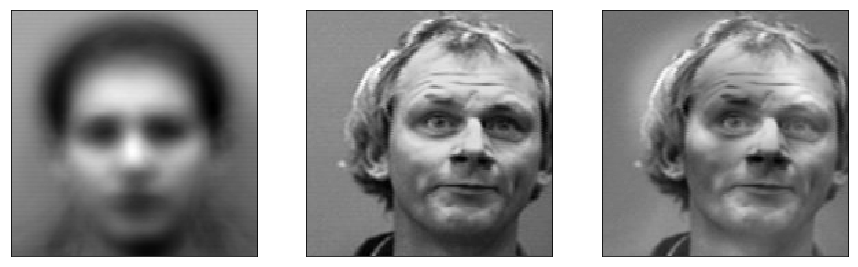

In [12]:
plt.rcParams['figure.figsize'] = [15,5]
data_set_vec_mean=np.reshape(np.mean(data_set_vec,axis=1),(-1,1))
data_no_mean=data_set_vec-data_set_vec_mean
fig, axs = plt.subplots(nrows=1, ncols=3)
foto=12
axs[0].imshow(np.reshape(data_set_vec_mean,(180,180)), cmap = plt.cm.gray)
axs[0].tick_params(labelleft=False, labelbottom=False, bottom=False,top=False,right=False,left=False, which='both')

axs[1].imshow(np.reshape(data_set_vec[:,foto],(180,180)), cmap = plt.cm.gray)
axs[1].tick_params(labelleft=False, labelbottom=False, bottom=False,top=False,right=False,left=False, which='both')

axs[2].imshow(np.reshape(data_no_mean[:,foto],(180,180)), cmap = plt.cm.gray)
axs[2].tick_params(labelleft=False, labelbottom=False, bottom=False,top=False,right=False,left=False, which='both')


# Calculo de los autovalores y autovectors y varainza explicada

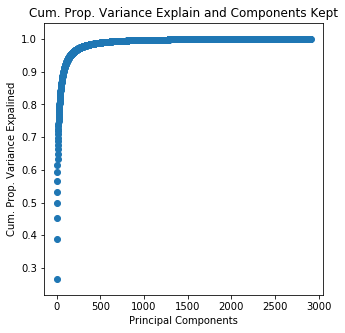

In [69]:
matrix_trick=np.dot(data_no_mean.transpose(),data_no_mean)
eigenvalues, eigenvectors = np.linalg.eigh(matrix_trick)
eig_pairs = [(eigenvalues[index], eigenvectors[:,index]) for index in range(len(eigenvalues))]


eigvalues_sort  = [eig_pairs[index][0] for index in range(len(eigenvalues))]
eigvectors_sort = [eig_pairs[index][1] for index in range(len(eigenvalues))]

plt.rcParams['figure.figsize'] = [5,5]
var_comp_sum = np.cumsum(eigvalues_sort)/sum(eigvalues_sort)

num_comp = range(1,len(eigvalues_sort)+1)
plt.title('Cum. Prop. Variance Explain and Components Kept')
plt.xlabel('Principal Components')
plt.ylabel('Cum. Prop. Variance Expalined')

plt.scatter(num_comp, var_comp_sum)
plt.show()

# Ejemplo de recontrucción de fotos

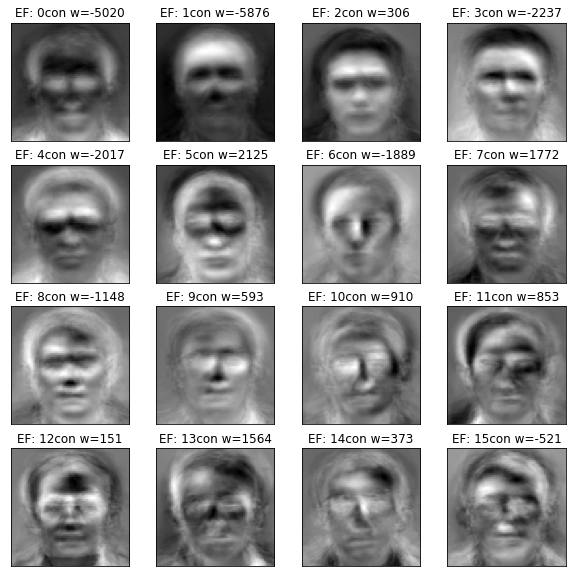

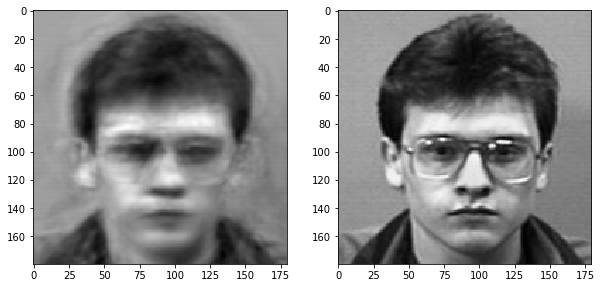

In [71]:
reduced_eig = np.array(eigvectors_sort[:100]).transpose()
eig_face = np.dot(data_no_mean,reduced_eig)
eig_face = eig_face.transpose()

for i in range(eig_face.shape[0]):
    eig_face[i,:]=eig_face[i,:]/np.linalg.norm(eig_face[i,:],ord=None)

W=np.dot(eig_face,data_no_mean)



plt.rcParams['figure.figsize'] = [10,10]

foto=2500
foto_rec=data_set_vec_mean.copy()

fig, axs = plt.subplots(nrows=4, ncols=4)
for i in range(eig_face.shape[0]):
    foto_rec+=W[i,foto]*np.reshape(eig_face[i,:],foto_rec.shape)
    f=int(i/4)
    c=i%4
    if (i<16):
        axs[f,c].imshow(np.reshape(eig_face[i,:],(180,180)), cmap = plt.cm.gray) #check
        axs[f,c].set_title('EF: '+str(i)+'con w='+str(int(W[i,foto])))
        axs[f,c].tick_params(labelleft=False, labelbottom=False, bottom=False,top=False,right=False,left=False, which='both')
plt.show();


plt.rcParams['figure.figsize'] = [10,15]

fig, axs = plt.subplots(nrows=1, ncols=2)

axs[0].imshow(np.reshape(foto_rec,(180,180)), cmap = plt.cm.gray)
axs[1].imshow(np.reshape(data_set_vec[:,foto],(180,180)), cmap = plt.cm.gray)
plt.show();


# Calculo de $\Omega$

In [72]:
reduced_eig = np.array(eigvectors_sort[:100]).transpose()
eig_face = np.dot(data_no_mean,reduced_eig)
eig_face = eig_face.transpose()

for i in range(eig_face.shape[0]):
    eig_face[i,:]=eig_face[i,:]/np.linalg.norm(eig_face[i,:],ord=None)

W=np.dot(eig_face,data_no_mean)


people=list(set(nombres))
Omega=np.zeros((W.shape[0],len(people)))
n=0
dist_centro=np.array([])
for p in people:
    dum=np.array(nombres)==p
    aux=np.mean(W[:,dum],axis=1)
    Omega[:,n]=aux
    dist_p=np.linalg.norm((W[:,dum]-np.reshape(aux,(W.shape[0],1))),axis=0)
    dist_centro=np.concatenate((dist_centro, dist_p), axis=None)
    n+=1

sns.distplot(dist_centro)
plt.title('Distribución de distancias en el espacio EF vs el centro de la clase')
plt.show()

# Ejemplo foto original vs su clase

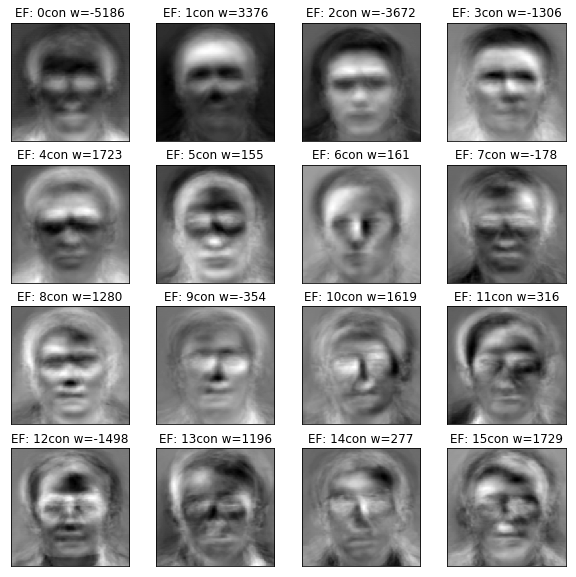

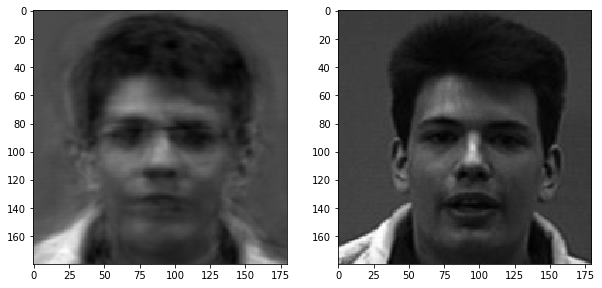

In [147]:
plt.rcParams['figure.figsize'] = [10,10]

foto=1
foto_rec=data_set_vec_mean.copy()

fig, axs = plt.subplots(nrows=4, ncols=4)
for i in range(eig_face.shape[0]):
    foto_rec+=Omega[i,foto]*np.reshape(eig_face[i,:],foto_rec.shape)
    f=int(i/4)
    c=i%4
    if (i<16):
        axs[f,c].imshow(np.reshape(eig_face[i,:],(180,180)), cmap = plt.cm.gray) #check
        axs[f,c].set_title('EF: '+str(i)+'con w='+str(int(W[i,foto])))
        axs[f,c].tick_params(labelleft=False, labelbottom=False, bottom=False,top=False,right=False,left=False, which='both')
plt.show();


plt.rcParams['figure.figsize'] = [10,15]

fig, axs = plt.subplots(nrows=1, ncols=2)


foto=nombres.index(people[1])+4
axs[0].imshow(np.reshape(foto_rec,(180,180)), cmap = plt.cm.gray)
axs[1].imshow(np.reshape(data_set_vec[:,foto],(180,180)), cmap = plt.cm.gray)
plt.show();

# Identificación de identidad particular

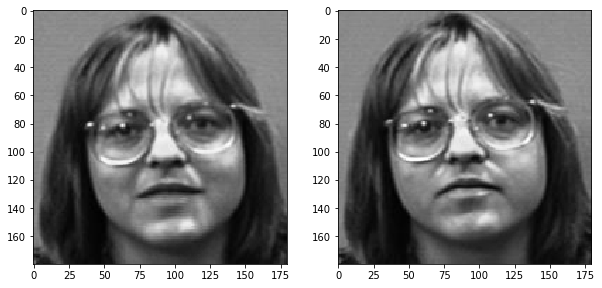

In [134]:
### New faces
epsilon=np.percentile(dist_centro,95)

new_no_mean=data_new_vec-data_set_vec_mean
W_new=np.dot(eig_face,new_no_mean)

foto=-1
dist_to_omega=np.linalg.norm((Omega-np.reshape(W_new[:,foto],(Omega.shape[0],1))),axis=0)

orden=np.argsort(np.array(dist_to_omega))

most_like=people[orden[0]]

if dist_to_omega.min() < epsilon:
    plt.rcParams['figure.figsize'] = [10,15]
    fig, axs = plt.subplots(nrows=1, ncols=2)

    axs[0].imshow(np.reshape(data_new_vec[:,foto],(180,180)), cmap = plt.cm.gray)
    
    se_supone=nombres.index(people[orden[0]])
    axs[1].imshow(np.reshape(data_set_vec[:,se_supone],(180,180)), cmap = plt.cm.gray)
    plt.show();
else:
    print ('Parece no estar en el data set, pero se supone que es {0}, su distancia fue {1}'.format(new_nombres[foto],dist_to_omega.min()))
    plt.rcParams['figure.figsize'] = [10,15]
    fig, axs = plt.subplots(nrows=1, ncols=2)

    axs[0].imshow(np.reshape(data_new_vec[:,foto],(180,180)), cmap = plt.cm.gray)
    
    se_supone=nombres.index(people[orden[0]])
    axs[1].imshow(np.reshape(data_set_vec[:,se_supone],(180,180)), cmap = plt.cm.gray)
    plt.show();


# Resultados generales de identidad

In [149]:
epsilon=np.percentile(dist_centro,99)


new_no_mean=data_new_vec-data_set_vec_mean
W_new=np.dot(eig_face,new_no_mean)

expected=[]
expected_extended=[]
for foto in range(W_new.shape[1]):
    dist_to_omega=np.linalg.norm((Omega-np.reshape(W_new[:,foto],(Omega.shape[0],1))),axis=0)

    orden=np.argsort(np.array(dist_to_omega))

    most_like=people[orden[0]]
    expected_extended.append(most_like)
    if dist_to_omega.min() < epsilon:
        expected.append(most_like)
    else:
        expected.append('Desconocida')

p=np.sum(np.array(expected)==np.array(new_nombres))/len(expected)

print('Con epsilon como el percentil 99 de las distancias se identifican el {} de las caras'.format(p))

p=np.sum(np.array(expected_extended)==np.array(new_nombres))/len(expected)     
print('Sin considerar un epsilon se identifican el {0} de las caras'.format(p))


Con epsilon como el percentil 99 de las distancias se identifican el 0.9934640522875817 de las caras
Sin considerar un epsilon se identifican el 1.0 de las caras
